In [1]:
import numpy as np
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import sys
sys.path.append("../../utilities/")
import data_utils
import evaluation_utils
import seaborn as sns
import umap
import math
from sklearn import metrics
from matplotlib import pyplot as plt
sys.path.append("../../src")
from dataset_class import dataset
from importlib import reload
evaluation_utils = reload(evaluation_utils)
from hmmlearn import hmm

In [124]:
from importlib import reload
import dataset_class
dataset_class = reload(dataset_class)
from dataset_class import dataset

In [170]:
def gene_expr_classification(gene_expression_path, annotation_path, annotation_resolution):
    annotation_dict = evaluation_utils.make_annotation_dict(annotation_path, annotation_resolution)
    expressions = []
    labels = []
    with open(gene_expression_path, 'r') as f:
        for line in f:
            gene_id, chr_num, pos1, pos2, _, gene_expr = line.rstrip("\n").split("\t")
            if not chr_num in [str(c) for c in np.arange(1,23)]:
                continue
            chr_name = 'chr{}'.format(chr_num)
            start = min(int(pos1),int(pos2))
            end = max(int(pos1),int(pos2))
            label = evaluation_utils.get_most_freq_label(chr_name, start, end, annotation_dict, annotation_resolution)
            if label == None:
                continue
            expressions.append(float(gene_expr))
            labels.append(label)
    return expressions, labels

def gene_expr_stat(gene_expression_path, annotation_path, annotation_resolution):
    expressions, labels = gene_expr_classification(gene_expression_path, annotation_path, annotation_resolution)
    expressions_df = pd.DataFrame({'label': labels, 'expression': expressions})
    expressions_df = expressions_df.replace(to_replace='None', value=np.nan).dropna()
    expressions_df['label'] = expressions_df['label'].astype(int)
    expr_stat = pd.DataFrame(expressions_df.groupby('label')['expression'].mean())
    return expr_stat

In [2]:
signals_names = ['DNase', 'H3K4me2', 'H3K27ac', 'H2A.Z', 'H3K9me3', 'H3K4me1', 'H3K27me3', 'H3K9ac', 'H3K4me3', 'H3K36me3', 'H3K79me2', 'H4K20me1']
datasets = {}
for res in [10000, 25000, 100000]:
    
    datasets[res] = dataset('GM12878', 'hg19', res, '../../data/GM12878/hg19/Hi-C/GSE63525_GM12878_insitu_primary_30.hic',
                     '../../utilities/juicer_tools_1.22.01.jar', '../../data/GM12878/hg19/Hi-C/res{}'.format(res),
                     signals_names, '../../data/GM12878/hg19/genomic-assays/bin_{}/'.format(res), 
                      '../../data/GM12878/hg19/res{}_datasets/'.format(res),
                      '../../data/', '../../utilities/config.json')
    datasets[res].load_pos2ind_and_ind2pos_maps('../../data/valid_bins/hg19/GM12878_{}_bins.txt'.format(res))

In [23]:
gene_expression_path = '../../data/GM12878/hg19/gene_expression/GM12878_genes_RPKM.txt'
RT_path = '../../data/GM12878/hg19/RT/six_phase/six_phases.txt'

In [3]:
signals_path = {10000: '../../data/GM12878/hg19/res10000_datasets/signals.txt',
               25000: '../../data/GM12878/hg19/res25000_datasets/signals.txt',
               100000: '../../data/GM12878/hg19/res100000_datasets/signals.txt'}
signals = {}
for res in [10000,25000,100000]:
    signals[res] = np.loadtxt(signals_path[res])

# annotation by kmeans, GMM, and HMM for different resolutions and k

In [81]:
'''
for res in [10000, 25000, 100000]:
    labels_df = pd.DataFrame()
    for k in np.arange(2,16):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(signals[res])
        l = kmeans.labels_
        labels_df['kmeans_{}'.format(k)] = l
    labels_df.to_csv('results/annotations/kmeans_res{}.txt'.format(res), sep = "\t", index = False)
    
for res in [10000, 25000, 100000]:
    labels_df = pd.DataFrame()
    for k in np.arange(2,16):
        gmm = GaussianMixture(n_components=k, random_state=0).fit(signals[res])
        l = gmm.predict(signals[res])
        labels_df['GMM_{}'.format(k)] = l
    labels_df.to_csv('results/annotations/GMM_res{}.txt'.format(res), sep = "\t", index = False)
    
for res in [10000, 25000, 100000]:
    lengths = datasets[res].get_chunks_lengths()
    labels_df = pd.DataFrame()
    for k in np.arange(2,16):
        gmm_hmm_viterbi = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
        gmm_hmm_viterbi.fit(signals[res], lengths)
        gmm_hmm_viterbi_labels = gmm_hmm_viterbi.predict(signals[res], lengths)
        labels_df['HMM_{}'.format(k)] = gmm_hmm_viterbi_labels
    labels_df.to_csv('results/annotations/HMM_res{}.txt'.format(res), sep = "\t", index = False)

for res in [10000]:
    labels_df = pd.DataFrame()
    for k in np.arange(3,9):
        gmm = GaussianMixture(n_components=k, random_state=0).fit(np.arcsinh(signals[res]))
        l = gmm.predict(np.arcsinh(signals[res]))
        labels_df['GMM_{}'.format(k)] = l
    labels_df.to_csv('results/annotations/norm_GMM_res{}.txt'.format(res), sep = "\t", index = False)
    
for res in [10000]:
    lengths = datasets[res].get_chunks_lengths()
    labels_df = pd.DataFrame()
    for k in np.arange(3,9):
        gmm_hmm_viterbi = hmm.GaussianHMM(n_components=k, covariance_type = 'full', algorithm='viterbi')
        gmm_hmm_viterbi.fit(np.arcsinh(signals[res]), lengths)
        gmm_hmm_viterbi_labels = gmm_hmm_viterbi.predict(np.arcsinh(signals[res]), lengths)
        labels_df['HMM_{}'.format(k)] = gmm_hmm_viterbi_labels
    labels_df.to_csv('results/annotations/norm_HMM_res{}.txt'.format(res), sep = "\t", index = False)
    
'''

# writing annotations

In [17]:
kmeans_labels = {}
GMM_labels = {}
HMM_labels = {}
for res in [10000, 25000, 100000]:
    kmeans_labels[res] = pd.read_csv('results/annotations/kmeans_res{}.txt'.format(res), sep = "\t")
    GMM_labels[res] = pd.read_csv('results/annotations/GMM_res{}.txt'.format(res), sep = "\t")
    HMM_labels[res] = pd.read_csv('results/annotations/HMM_res{}.txt'.format(res), sep = "\t")

In [18]:
for res in [10000, 25000, 100000]:
    for k in np.arange(2,16):
        annot_dir_path = '../../data/GM12878/hg19/res{}_datasets/annotations/kmeans/'.format(res)
        datasets[res].write_annotation(kmeans_labels[res]['kmeans_{}'.format(k)],
                                      'kmeans_{}'.format(k), annot_dir_path)
        
        annot_dir_path = '../../data/GM12878/hg19/res{}_datasets/annotations/gmm/'.format(res)
        datasets[res].write_annotation(GMM_labels[res]['GMM_{}'.format(k)],
                                      'gmm_{}'.format(k), annot_dir_path)
        
        annot_dir_path = '../../data/GM12878/hg19/res{}_datasets/annotations/hmm/'.format(res)
        datasets[res].write_annotation(HMM_labels[res]['HMM_{}'.format(k)],
                                      'hmm_{}'.format(k), annot_dir_path)
        
for k in np.arange(3,9):
    datasets[10000].read_segway_annotation('../Segway/res10000/functional/annot_k{}/segway.bed.gz'.format(k)
                                           , 'segway_{}'.format(k))
    datasets[10000].write_annotation(datasets[10000].labels['segway_{}'.format(k)], 'segway_{}'.format(k),
                                    '../../data/GM12878/hg19/res10000_datasets/annotations/segway/')

In [83]:
norm_GMM_labels = pd.read_csv('results/annotations/norm_GMM_res10000.txt', sep = "\t")
norm_HMM_labels = pd.read_csv('results/annotations/norm_HMM_res10000.txt', sep = "\t")
for k in np.arange(3,9):
    annot_dir_path = '../../data/GM12878/hg19/res10000_datasets/annotations/norm_gmm/'
    datasets[10000].write_annotation(norm_GMM_labels['GMM_{}'.format(k)],
                                      'norm_gmm_{}'.format(k), annot_dir_path)
        
    annot_dir_path = '../../data/GM12878/hg19/res10000_datasets/annotations/norm_hmm/'
    datasets[10000].write_annotation(norm_HMM_labels['HMM_{}'.format(k)],
                                      'norm_hmm_{}'.format(k), annot_dir_path)
    

# comparison for resolution 10000

In [211]:
'''
stats_df = []
for method in ['gmm', 'hmm', 'segway', 'norm_gmm', 'norm_hmm']:
    for k in np.arange(3,9):
        print('calculating stats for method {} and k = {}'.format(method,k))
        annot_path = '../../data/GM12878/hg19/res10000_datasets/annotations/{}/{}_{}_annotation.txt'.format(method, method, k)
        df = pd.read_csv(annot_path, header = None, sep = "\t")
        df['length'] = df.iloc[:,2] - df.iloc[:,1]
        avg_length = np.mean(df['length'])
        num_domains = df.shape[0]
        ge_ve = evaluation_utils.gene_expression_ve(gene_expression_path, annot_path, 10000)
        RT_score, _ = evaluation_utils.RT_scores(RT_path, annot_path, 10000)
        stats_df.append({'method': method, 'k': k, 'avg_length': avg_length, 'num_domains': num_domains,
                        'ge_ve': ge_ve, 'RT_score': RT_score})
stats_df = pd.DataFrame(stats_df)
'''

In [96]:
stats_df.to_csv('results/bes/res10k_comp.txt', sep = '\t', index = False)

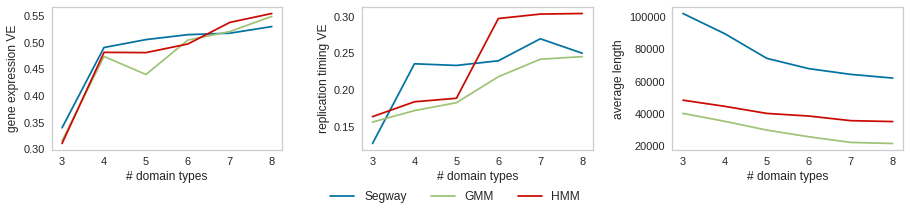

In [237]:
fig, axs = plt.subplots(1,3, figsize = (13,3))

sns.lineplot(data = stats_df.iloc[12:,:], x = 'k', y = 'ge_ve', hue = 'method', ax = axs[0])
axs[0].get_legend().remove()
axs[0].grid(False)
axs[0].set_xlabel('# domain types', size = 12)
axs[0].set_ylabel('gene expression VE', size = 12)
axs[0].tick_params(axis='both', labelsize = 11)

sns.lineplot(data = stats_df.iloc[12:,:], x = 'k', y = 'RT_score', hue = 'method', ax = axs[1])
axs[1].get_legend().remove()
axs[1].grid(False)
axs[1].set_xlabel('# domain types', size = 12)
axs[1].set_ylabel('replication timing VE', size = 12)
axs[1].tick_params(axis='both', labelsize = 11)


sns.lineplot(data = stats_df.iloc[12:,:], x = 'k', y = 'avg_length', hue = 'method', ax = axs[2])
axs[2].get_legend().remove()
axs[2].grid(False)
axs[2].set_xlabel('# domain types', size = 12)
axs[2].set_ylabel('average length', size = 12)
axs[2].tick_params(axis='both', labelsize = 11)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, ['Segway', 'GMM', 'HMM'], loc="lower center", ncol=5, borderaxespad=0.1, fontsize = 12)

fig.tight_layout(pad=2.0)

fig.savefig('number of epigenomic domain types justification/other_signals_ve.png', dpi = 300,
            bbox_inches='tight',facecolor='white', transparent=False)

In [58]:
chr_name = ['chr1']
start_ind = np.cumsum(datasets[10000].get_chunks_lengths())[18]
end_ind = np.cumsum(datasets[10000].get_chunks_lengths())[19]-1
start_pos = datasets[10000].ind2pos_dict[start_ind][1]
end_pos = datasets[10000].ind2pos_dict[end_ind][1]

In [65]:
print(start_pos, end_pos)

7281 10378


In [125]:
for method in ['gmm', 'hmm', 'segway', 'norm_gmm', 'norm_hmm']:
    annot_path = '../../data/GM12878/hg19/res10000_datasets/annotations/{}/{}_6_annotation.txt'.format(method, method)
    datasets[10000].read_annotation(annot_path, method)

In [107]:
start_ind2 = int(datasets[10000].pos2ind_dict['chr1'][8500])
end_ind2 = int(datasets[10000].pos2ind_dict['chr1'][9500])

<AxesSubplot:>

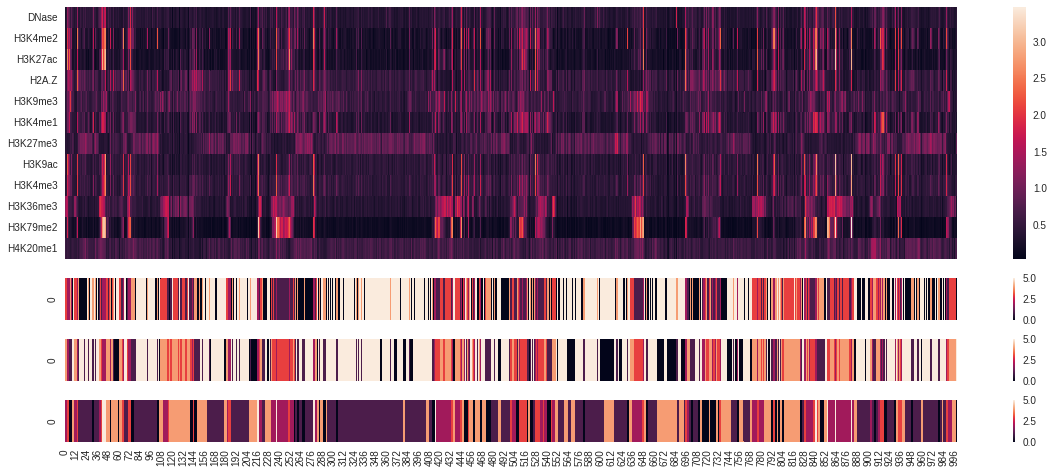

In [115]:
fig, axs = plt.subplots(nrows=4,figsize=(20, 8),sharex=True, 
                        gridspec_kw={'height_ratios': [6, 1, 1, 1]})
sns.heatmap(np.arcsinh(signals[10000][start_ind2:end_ind2,].transpose()), ax = axs[0])
axs[0].set_yticklabels(signals_names, rotation = 0)
sns.heatmap(datasets[10000].labels['norm_gmm'][start_ind2:end_ind2].astype(int).reshape(1,-1), ax = axs[1])
sns.heatmap(datasets[10000].labels['norm_hmm'][start_ind2:end_ind2].astype(int).reshape(1,-1), ax = axs[2])
sns.heatmap(datasets[10000].labels['segway'][start_ind2:end_ind2].astype(int).reshape(1,-1), ax = axs[3])

In [183]:
gmm_annot_path = '../../data/GM12878/hg19/res10000_datasets/annotations/gmm/gmm_6_annotation.txt'
hmm_annot_path = '../../data/GM12878/hg19/res10000_datasets/annotations/hmm/hmm_6_annotation.txt'
segway_annot_path = '../../data/GM12878/hg19/res10000_datasets/annotations/segway/segway_6_annotation.txt'

In [118]:
signals_annots_df = pd.DataFrame(signals[10000])
signals_annots_df.columns = signals_names
signals_annots_df['gmm'] = datasets[10000].labels['norm_gmm']
signals_annots_df['hmm'] = datasets[10000].labels['norm_hmm']
signals_annots_df['segway'] = datasets[10000].labels['segway']
datasets[10000].read_annotation('../../data/GM12878/hg19/annotations/GSE63525_GM12878_subcompartments.bed',
                               'SC')
signals_annots_df['SC'] = datasets[10000].labels['SC']
signals_annots_df = signals_annots_df.replace(to_replace='None', value=np.nan).dropna()

In [119]:
gmm_enrichments = evaluation_utils.enrichment_scores_(signals_annots_df, signals_names, 'gmm')
hmm_enrichments = evaluation_utils.enrichment_scores_(signals_annots_df, signals_names, 'hmm')
segway_enrichments = evaluation_utils.enrichment_scores_(signals_annots_df, signals_names, 'segway')

[Text(0.5, 0, '')]

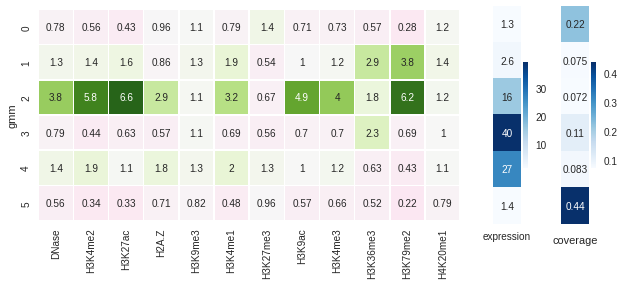

In [184]:
gmm_expr_stat = gene_expr_stat(gene_expression_path, gmm_annot_path, 10000)

gmm_coverage = np.unique(signals_annots_df['gmm'].values[signals_annots_df['gmm'].values != None].astype(int), return_counts = True)[1]
gmm_coverage = gmm_coverage/np.sum(gmm_coverage)

fig, axs = plt.subplots(ncols=3,figsize=(10,4),sharey=True, 
                        gridspec_kw={'width_ratios': [12, 1, 1]})
sns.heatmap(gmm_enrichments, cmap="PiYG", center = 1, linewidths=.5, 
            square = True, cbar = False, annot = True, ax = axs[0])
sns.heatmap(gmm_expr_stat, ax = axs[1], cmap = 'Blues', annot = True)
axs[1].set_ylabel('')
sns.heatmap(gmm_coverage.reshape(-1,1), ax = axs[2], cmap = 'Blues', annot = True)
axs[2].set_xlabel('coverage')
axs[2].set_xticklabels([])

[Text(0.5, 0, '')]

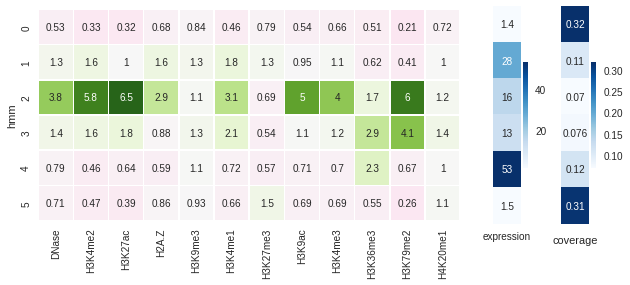

In [180]:
#hmm_expr_stat = gene_expr_stat(gene_expression_path, hmm_annot_path, 10000)

#hmm_coverage = np.unique(signals_annots_df['hmm'].values[signals_annots_df['hmm'].values != None].astype(int), return_counts = True)[1]
#hmm_coverage = hmm_coverage/np.sum(hmm_coverage)

fig, axs = plt.subplots(ncols=3,figsize=(10,4),sharey=True, 
                        gridspec_kw={'width_ratios': [12, 1, 1]})
sns.heatmap(hmm_enrichments, cmap="PiYG", center = 1, linewidths=.5, 
            square = True, cbar = False, annot = True, ax = axs[0])
sns.heatmap(hmm_expr_stat, ax = axs[1], cmap = 'Blues', annot = True)
axs[1].set_ylabel('')
sns.heatmap(hmm_coverage.reshape(-1,1), ax = axs[2], cmap = 'Blues', annot = True)
axs[2].set_xlabel('coverage')
axs[2].set_xticklabels([])

[Text(0.5, 0, '')]

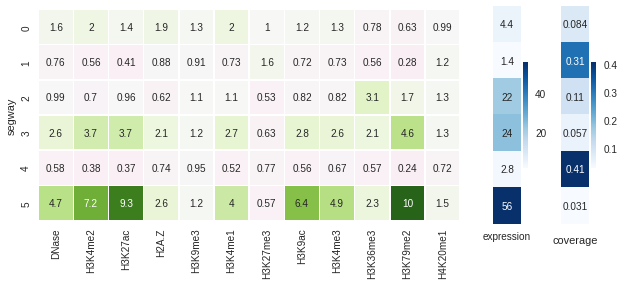

In [179]:
#segway_expr_stat = gene_expr_stat(gene_expression_path, segway_annot_path, 10000)

#segway_coverage = np.unique(signals_annots_df['segway'].values[signals_annots_df['segway'].values != None].astype(int), return_counts = True)[1]
#segway_coverage = segway_coverage/np.sum(segway_coverage)

fig, axs = plt.subplots(ncols=3,figsize=(10,4),sharey=True, 
                        gridspec_kw={'width_ratios': [12, 1, 1]})
sns.heatmap(segway_enrichments, cmap="PiYG", center = 1, linewidths=.5, 
            square = True, cbar = False, annot = True, ax = axs[0])
sns.heatmap(segway_expr_stat, ax = axs[1], cmap = 'Blues', annot = True)
axs[1].set_ylabel('')
sns.heatmap(segway_coverage.reshape(-1,1), ax = axs[2], cmap = 'Blues', annot = True)
axs[2].set_xlabel('coverage')
axs[2].set_xticklabels([])

In [206]:
methods = ['gmm', 'hmm', 'segway', 'SC']
ARI_df = pd.DataFrame(index = methods, columns = methods)
for m, method1 in enumerate(methods):
    for method2 in methods[m:]:
        ARI = metrics.adjusted_rand_score(signals_annots_df[method1],signals_annots_df[method2])
        ARI_df.loc[method1,method2] = ARI

In [207]:
ARI_df

,gmm,hmm,segway,SC
gmm,1,0.565995,0.36468,0.192846
hmm,NaN,1,0.523017,0.174939
segway,NaN,NaN,1,0.151175
SC,NaN,NaN,NaN,1


([<matplotlib.axis.YTick at 0x7f988394f9b0>,
 [Text(0, 0.5, 'DNase'),
  Text(0, 1.5, 'H3K4me2'),
  Text(0, 2.5, 'H3K27ac'),
  Text(0, 3.5, 'H2A.Z'),
  Text(0, 4.5, 'H3K9me3'),
  Text(0, 5.5, 'H3K4me1'),
  Text(0, 6.5, 'H3K27me3'),
  Text(0, 7.5, 'H3K9ac'),
  Text(0, 8.5, 'H3K4me3'),
  Text(0, 9.5, 'H3K36me3'),
  Text(0, 10.5, 'H3K79me2'),
  Text(0, 11.5, 'H4K20me1')])

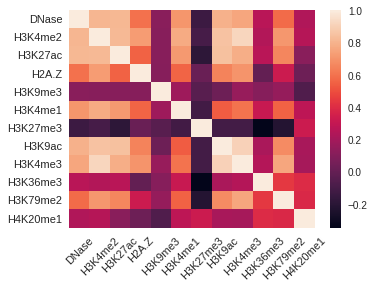

In [212]:
fig = plt.figure(figsize = (5.5,4))
ax = sns.heatmap(np.corrcoef(signals[10000].transpose()))
#ax.set_xticks(range(12), signals_names)
plt.xticks(np.arange(12)+0.5,signals_names, rotation = 45, size = 11)
plt.yticks(np.arange(12)+0.5,signals_names, rotation = 0, size = 11)
fig.savefig('number of epigenomic domain types justification/signals_correlation.png', dpi = 300,
            bbox_inches='tight',facecolor='white', transparent=False)

In [220]:
signals_annots_df2 = pd.DataFrame(signals[10000])
signals_annots_df2.columns = signals_names
signals_annots_df2 = pd.concat([signals_annots_df2,HMM_labels[10000]], axis = 1)

In [229]:
ve_df = []
for signal_name in signals_names:
    for k in np.arange(3,9):
        ve = evaluation_utils.variance_explained(signals_annots_df2[signal_name].values, 
                                                 signals_annots_df2['HMM_{}'.format(k)].values)
        ve_df.append({'signal_name': signal_name, 'k': k, 've': ve})
ve_df = pd.DataFrame(ve_df)

In [233]:
ve_df.to_csv('number of epigenomic domain types justification/hmm_input_signals_ve.txt', sep = '\t', index = False)

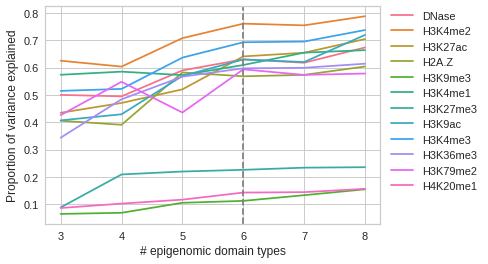

In [231]:
fig = plt.figure(figsize = (6,4))
ax = sns.lineplot(data = ve_df, x = 'k', y = 've', hue = 'signal_name')
ax.set_xlabel('# epigenomic domain types', size = 12)
ax.set_ylabel('Proportion of variance explained', size = 12)
ax.tick_params(axis='both', labelsize = 11)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize = 11)
plt.axvline(6, 0,1, color="grey", linestyle="--")
fig.savefig('number of epigenomic domain types justification/input_signals_ve.png', dpi = 300,
            bbox_inches='tight',facecolor='white', transparent=False)